## Import

In [1]:
import os
import numpy as np
import fitsio

In [2]:
import fsps
import sedpy
import prospect
import time
import emcee
import h5py
import plot_utils as pread

from prospect.models import priors, sedmodel
from sedpy.observate import load_filters
from prospect import fitting
from scipy.optimize import minimize
from prospect.io import read_results, write_results
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Setup the models

In [4]:
from prospect.models import model_setup
from prospect.sources import CSPBasis

In [5]:
# Specify the run parameters.
run_params = {
              'param_file': '',
              'outfile': 'test',
              'verbose': True,
              'debug': False,
              'nwalkers': 10, # 128,
              'nburn': [32, 32, 64], 
              'niter': 100, # 512,
    
              'do_powell': True,
              'ftol': 0.5e-5, 'maxfev': 5000,
              #'initial_disp': 0.1,
              # Data parameters
              #'snr': 20.0, # ???
              #'add_noise': False, # ???
              # Model parameters
              #'mass': 1e10,
              #'logzsol': -0.5,
              #'tage': 12.0,
              #'tau': 3.0,
              #'dust2': 0.3,
              # Data manipulation parameters
              #'logify_spectrum': False,
              #'normalize_spectrum': False,
              #'wlo':3750., 'whi':7200.,
              # SPS parameters
              'zcontinuous': 1,
              }
print(run_params)

{'param_file': '', 'outfile': 'test', 'verbose': True, 'debug': False, 'nwalkers': 10, 'nburn': [32, 32, 64], 'niter': 100, 'do_powell': True, 'ftol': 5e-06, 'maxfev': 5000, 'zcontinuous': 1}


In [6]:
sdss = ['sdss_{}0'.format(b) for b in ['u','g','r','i','z']]
wise = ['wise_{}'.format(b) for b in ['w1','w2']]
filternames = sdss + wise
print(filternames)

['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0', 'wise_w1', 'wise_w2']


In [7]:
# load sps model (default)
#sps = model_setup.load_sps(**run_params)
sps = CSPBasis(zcontinuous=1, compute_vega_mags=False)

In [8]:
print(sps.csp.libraries)

(b'pdva', b'basel')


In [9]:
filters = load_filters(filternames)
print(filters)

[<class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2)]


In [10]:
# create a function to read in the redmapper catalog and extract relavent files
def readred():
    redfile = os.path.join(os.sep, 'global', 'work', 'projects', 
                           'redmapper', 'redmapper_isedfit_v5.10_centrals.fits.gz')
    info = fitsio.FITS(redfile)
    # hack, read just one galaxy
    cat = info[1].read(rows=3)
    
    return cat

In [11]:
# Build output dictionary which contains the input photometry (our version of load_obs).
def prospcat(redcat):
    mask = (redcat['IVARMAGGIES'] > 0) * 1
    obs = {}
    obs['maggies'] = np.squeeze(redcat['MAGGIES'])
    with np.errstate(divide='ignore'):
        obs['maggies_unc'] = np.squeeze(1.0/np.sqrt(redcat['IVARMAGGIES'])) #[:3, :])
    obs['wavelength'] = None # not fitting spectra
    obs['filternames'] = filternames
    obs['filters'] = load_filters(filternames)
    obs['phot_mask'] = mask  # 1 = good, 0 = bad
    obs['isedfit_id'] = redcat['ISEDFIT_ID']
    obs['zred'] = redcat['Z']
    
    # NOT SURE IF CORRECT
    obs['unc'] = obs['maggies_unc']
    obs['spectrum'] = None
    
    return obs

In [12]:
redcat = readred()

In [13]:
obs = prospcat(redcat)

In [14]:
# Load the (default?) SPS model
def load_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    sps = CSPBasis(zcontinuous=zcontinuous,
                   compute_vega_mags=compute_vega_mags)
    return sps

In [15]:
sps = load_sps(**run_params)

In [16]:
# I don't think we need to load a noise model since we're only fitting photometry.(?)
spec_noise, phot_noise = model_setup.load_gp(**run_params)

In [17]:
# Initialize the priors and then load the (default?) model.
# TBD: Do we need to define priors on dust, fburst, etc., etc.???
def load_model(zred, **extras):
    model_params = []
    
    # Prior on distance / redshift.
    model_params.append({'name': 'zred', 'N': 1,
                         'isfree': False,
                         'init': zred,
                         'units': '',
                         'prior_function': priors.tophat,
                         'prior_args': {'mini': 0.0, 'maxi': 4.0}})
    
    # Prior on SFH.
    model_params.append({'name': 'sfh', 'N': 1,
                         'isfree': False,
                         'init': 4,
                         'units': 'type'})

    model_params.append({'name': 'mass', 'N': 1,
                         'isfree': True,
                         'init': 5e11,
                         'init_disp': 1e9,
                         'units': r'M_\odot',
                         'prior_function': priors.tophat,
                         'prior_args': {'mini': 1e8, 'maxi': 3e12}})

    model_params.append({'name': 'logzsol', 'N': 1,
                         'isfree': False,
                         'init': -0.3,
                         'init_disp': 0.3,
                         'units': r'$\log (Z/Z_\odot)$',
                         'prior_function': priors.tophat,
                         'prior_args': {'mini':-1, 'maxi':0.19}})
    
    # Metallicity, tau, and age priors
    # If zcontinuous > 1, use 3-pt smoothing
    model_params.append({'name': 'pmetals', 'N': 1,
                         'isfree': False,
                         'init': 0.02,})
                        
    model_params.append({'name': 'tau', 'N': 1,
                         'isfree': False,
                         'init': 1.0,
                         'init_disp': 0.5,
                         'units': 'Gyr',
                         'prior_function': priors.logarithmic,
                         'prior_args': {'mini': 0.1, 'maxi': 100}})

    model_params.append({'name': 'tage', 'N': 1,
                        'isfree': True,
                        'init': 10.0,
                        'init_disp': 3.0,
                        'units': 'Gyr',
                        'prior_function': priors.tophat,
                        'prior_args': {'mini': 0.101, 'maxi': 14.0}})
    
    return sedmodel.SedModel(model_params)

In [18]:
model = load_model(obs['zred'], **run_params)

In [19]:
# Define our likelihood function
def lnprobfn(theta, verbose=True):
    """Given a parameter vector and a dictionary of observational data and a model object, 
    return the ln of the posterior. This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    lnp_prior = model.prior_product(theta)
    if isfinite(lnp_prior):
        
        # Generate mean model
        t1 = time.time()
        try:
            mu, phot, x = model.mean_model(theta, obs, sps=sps)
        except(ValueError):
            return -np.infty
        d1 = time.time() - t1

        # Noise modeling
        if spec_noise is not None:
            spec_noise.update(**model.params)
        if phot_noise is not None:
            phot_noise.update(**model.params)
        vectors = {'spec': mu, 'unc': obs['unc'],
                   'sed': model._spec, 'cal': model._speccal,
                   'phot': phot, 'maggies_unc': obs['maggies_unc']}

        # Calculate log-likelihoods
        t2 = time.time()
        lnp_spec = lnlike_spec(mu, obs=obs, spec_noise=spec_noise, **vectors)
        lnp_phot = lnlike_phot(phot, obs=obs, phot_noise=phot_noise, **vectors)
        d2 = time.time() - t2
        if verbose:
            write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

        return lnp_prior + lnp_phot + lnp_spec

    else:
        return -np.infty

# Running Prospector

### Outputs

In [20]:
outroot = "{0}_{1}".format(run_params['outfile'], int(time.time()))
try:
    hfilename = '{}_mcmc.h5'.format(outroot)
    hfile = h5py.File(hfilename, "a")
    print("Writing to file {}".format(hfilename))
    write_results.write_h5_header(hfile, run_params, model)
    write_results.write_obs_to_h5(hfile, obs)
except:
    hfile = None

Writing to file test_1496342003_mcmc.h5
Could not JSON serialize model_params, pickled instead


### Model Preview

In [21]:
print('Free parameters: ', model.free_params)
print('Fixed parameters: ', model.fixed_params)

Free parameters:  ['mass', 'tage']
Fixed parameters:  ['zred', 'sfh', 'logzsol', 'pmetals', 'tau']


### SED Preview

In [22]:
model.initial_theta

array([  5.00000000e+11,   1.00000000e+01])

In [23]:
sps.csp.wavelengths

array([  9.10000000e+01,   9.40000000e+01,   9.60000000e+01, ...,
         9.81700000e+07,   9.90800000e+07,   1.00000000e+08])

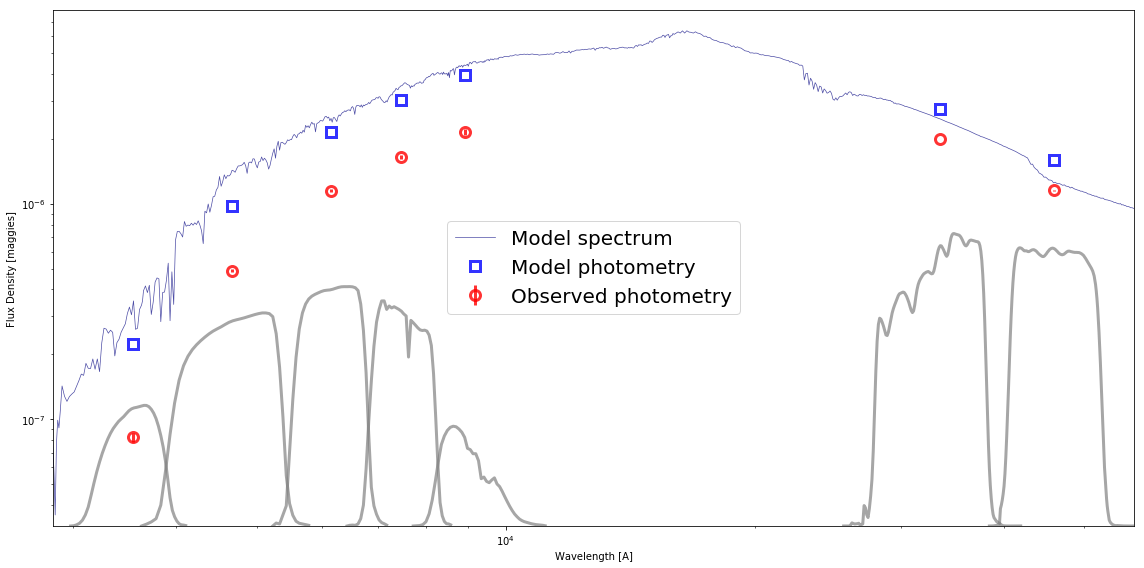

In [24]:
wspec = sps.csp.wavelengths # spectral wavelengths
wphot = array([f.wave_effective for f in obs['filters']]) # photometric effective wavelengths
wphot_width = array([f.effective_width for f in obs['filters']]) # photometric effective widths

initial_theta = model.rectify_theta(model.initial_theta) # initial parameters
mspec_init, mphot_init, mextra_init = model.mean_model(initial_theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec_init)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in range(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()



### Minimization Step

In [25]:
# Do we actually need this?
try:
    from emcee.utils import MPIPool
    pool = MPIPool(debug=False, loadbalance=True)
    if not pool.is_master():
        # Wait for instructions from the master process.
        pool.wait()
        sys.exit(0)
except(ImportError, ValueError):
    pool = None
    print('Not using MPI')

Not using MPI


In [26]:
def halt(message):
    """Exit, closing pool safely.
    """
    print(message)
    try:
        pool.close()
    except:
        pass

In [27]:
def chisqfn(theta):
    """Negative of lnprobfn for minimization, and also handles passing in
    keyword arguments which can only be postional arguments when using scipy
    minimize.
    """
    return -lnprobfn(theta)

verbose=False # don't output function calls

# start minimization
min_method = 'Nelder-Mead'
ts = time.time()
min_results = minimize(chisqfn, initial_theta, method=min_method)
pdur = time.time() - ts

# reinitialize fit
initial_center = fitting.reinitialize(min_results.x, model, edge_trunc=run_params.get('edge_trunc', 0.1))
initial_prob = -1 * min_results['fun']

# output results
print('done {0} in {1}s'.format(min_method,pdur))
print('best {0} guess: {1}'.format(min_method,initial_center))
print('best {0} lnp: {1}'.format(min_method,initial_prob))

[  5.00000000e+11   1.00000000e+01]
model calc = 0.003663301467895508s, lnlike calc = 0.00010204315185546875
lnp = -10000.238341321208, lnp_spec = 0.0, lnp_phot = -10000.238341321208
[  5.25000000e+11   1.00000000e+01]
model calc = 0.001850128173828125s, lnlike calc = 6.341934204101562e-05
lnp = -12122.395435572633, lnp_spec = 0.0, lnp_phot = -12122.395435572633
[  5.00000000e+11   1.05000000e+01]
model calc = 0.01245880126953125s, lnlike calc = 6.341934204101562e-05
lnp = -7812.136393760899, lnp_spec = 0.0, lnp_phot = -7812.136393760899
[  4.75000000e+11   1.05000000e+01]
model calc = 0.0017642974853515625s, lnlike calc = 6.270408630371094e-05
lnp = -6214.987641656104, lnp_spec = 0.0, lnp_phot = -6214.987641656104
[  4.50000000e+11   1.07500000e+01]
model calc = 0.011452674865722656s, lnlike calc = 6.365776062011719e-05
lnp = -4175.847834072981, lnp_spec = 0.0, lnp_phot = -4175.847834072981
[  4.50000000e+11   1.12500000e+01]
model calc = 0.011541366577148438s, lnlike calc = 6.3180923

lnp = 123.15818004498715, lnp_spec = 0.0, lnp_phot = 123.15818004498715
[  3.27593832e+11   1.28905147e+01]
model calc = 0.012247800827026367s, lnlike calc = 6.365776062011719e-05
lnp = 123.15818702991692, lnp_spec = 0.0, lnp_phot = 123.15818702991692
[  3.25559732e+11   1.28009727e+01]
model calc = 0.011587142944335938s, lnlike calc = 6.341934204101562e-05
lnp = 123.1581878581263, lnp_spec = 0.0, lnp_phot = 123.1581878581263
[  3.24108494e+11   1.27371822e+01]
model calc = 0.011611461639404297s, lnlike calc = 6.318092346191406e-05
lnp = 123.15817915056759, lnp_spec = 0.0, lnp_phot = 123.15817915056759
[  3.24394010e+11   1.27494695e+01]
model calc = 0.011597633361816406s, lnlike calc = 6.341934204101562e-05
lnp = 123.15817196831111, lnp_spec = 0.0, lnp_phot = 123.15817196831111
[  3.26793876e+11   1.28552534e+01]
model calc = 0.011528491973876953s, lnlike calc = 6.246566772460938e-05
lnp = 123.15818721463062, lnp_spec = 0.0, lnp_phot = 123.15818721463062
[  3.25193965e+11   1.27847308

lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26037616e+11   1.28219085e+01]
model calc = 0.012258291244506836s, lnlike calc = 6.29425048828125e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26035408e+11   1.28218116e+01]
model calc = 0.011557579040527344s, lnlike calc = 6.341934204101562e-05
lnp = 123.15818786621092, lnp_spec = 0.0, lnp_phot = 123.15818786621092
[  3.26037064e+11   1.28218843e+01]
model calc = 0.011796236038208008s, lnlike calc = 6.29425048828125e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26036512e+11   1.28218601e+01]
model calc = 0.011605501174926758s, lnlike calc = 6.29425048828125e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26033243e+11   1.28217166e+01]
model calc = 0.011597633361816406s, lnlike calc = 6.246566772460938e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26032139e+11   1.28216682e

[  3.26028872e+11   1.28215248e+01]
model calc = 0.01208949089050293s, lnlike calc = 6.318092346191406e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028871e+11   1.28215248e+01]
model calc = 0.011580467224121094s, lnlike calc = 6.29425048828125e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028872e+11   1.28215248e+01]
model calc = 0.011670112609863281s, lnlike calc = 7.033348083496094e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028872e+11   1.28215248e+01]
model calc = 0.011606454849243164s, lnlike calc = 6.29425048828125e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028871e+11   1.28215248e+01]
model calc = 0.0115966796875s, lnlike calc = 6.270408630371094e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215248e+01]
model calc = 0.012405872344970703s, lnlike calc = 0.00015592575073242188

lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215247e+01]
model calc = 0.012128114700317383s, lnlike calc = 6.389617919921875e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215247e+01]
model calc = 0.011644840240478516s, lnlike calc = 6.270408630371094e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215247e+01]
model calc = 0.011602640151977539s, lnlike calc = 6.341934204101562e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215247e+01]
model calc = 0.011522054672241211s, lnlike calc = 7.081031799316406e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215247e+01]
model calc = 0.011592388153076172s, lnlike calc = 6.270408630371094e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.282152

lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215247e+01]
model calc = 0.012513875961303711s, lnlike calc = 6.29425048828125e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215247e+01]
model calc = 0.01169586181640625s, lnlike calc = 6.29425048828125e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215247e+01]
model calc = 0.0019114017486572266s, lnlike calc = 6.222724914550781e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215247e+01]
model calc = 0.0018465518951416016s, lnlike calc = 6.341934204101562e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.28215247e+01]
model calc = 0.0018458366394042969s, lnlike calc = 6.29425048828125e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  3.26028870e+11   1.2821524

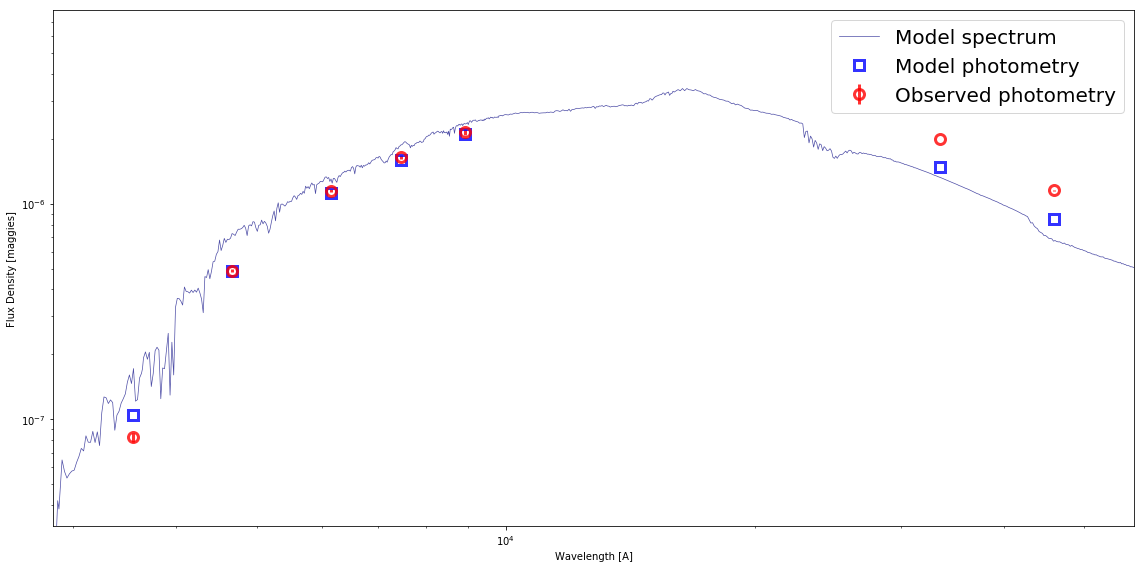

In [28]:
# Check that we got closer!
mspec_init, mphot_init, mextra_init = model.mean_model(min_results.x, obs, sps=sps) # generate model

# plotting 
figure(figsize=(16,8))
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

### Sampling the Posterior

In [29]:
postkwargs = {}

fout = sys.stdout
fnull = open(os.devnull, 'w')
sys.stdout = fnull

tstart = time.time()
out = fitting.run_emcee_sampler(lnprobfn, initial_center, model,
                                postkwargs=postkwargs, initial_prob=initial_prob,
                                pool=pool, hdf5=hfile, **run_params)
esampler, burn_p0, burn_prob0 = out
edur = time.time() - tstart

sys.stdout = fout

print('done emcee in {0}s'.format(edur))

done emcee in 23.593186616897583s


In [30]:
# Pick a random walker at the end!
theta = esampler.chain[5, run_params['niter']-1, :]
print(theta)

mspec_init, mphot_init, mextra_init = model.mean_model(theta, obs, sps=sps) # generate model

# plotting 
figure(figsize=(16,8))
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()



IndexError: index 99 is out of bounds for axis 1 with size 0

In [31]:
# Saves results to a disk - Error 
write_results.write_pickles(run_params, model, obs, esampler, min_results,
                            outroot=outroot, toptimize=pdur, tsample=edur,
                            sampling_initial_center=initial_center,
                            post_burnin_center=burn_p0,
                            post_burnin_prob=burn_prob0)

if hfile is None:
    hfile = hfilename
write_results.write_hdf5(hfile, run_params, model, obs, esampler, min_results,
                         toptimize=pdur, tsample=edur,                         
                         sampling_initial_center=initial_center,
                         post_burnin_center=burn_p0,
                         post_burnin_prob=burn_prob0)

halt('Finished')

TypeError: expected str, bytes or os.PathLike object, not File

# Visualizing the Results

In [32]:
# grab results, powell results, and our corresponding models -Error
res, pr, mod = read_results.results_from("{}_1496243536_mcmc.h5".format(run_params['outfile']))

KeyError: "Unable to open object (Object 'obs' doesn't exist)"